# **Section 1: Importing Required Libraries**

In this section we bring in all the Python packages we need.


*   pandas, numpy: data handling
*   matplotlib, seaborn: plotting

*   ipywidgets: interactive UI controls
*   scikit-learn: modeling (LinearRegression, train_test_split)






In [ ]:
# 📦 Importing required libraries
import pandas as pd
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, clear_output
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


# **Section 2: Loading the Dataset**

Here we load our CSV of used‑car listings. It contains columns like:



*   name (full model name)
*   year (manufacture year)

*   km_driven
*   fuel, seller_type, transmission, owner (categorical descriptors)

*   selling_price (the value we want to predict)


We then print out the number of rows/columns and peek at the first few entries to confirm it loaded correctly.













In [ ]:
# 🔄 Load CSV into DataFrame
df = pd.read_csv('/content/CAR DETAILS FROM CAR DEKHO.csv')


# **Section 3: Data Preprocessing & Feature Engineering**

Raw data often isn’t ready for a machine learning model. In this section we:


1.   Extract a simplified Car_Model (first two words of the full name) so we can group by model.
2.   Drop the original name column to avoid redundancy.

3.   One‑hot encode all categorical variables (fuel, seller_type, transmission, owner, and our new Car_Model) so they become numeric inputs.

After encoding, we print the new DataFrame shape to see how many features we now have.



In [ ]:
# 🛠️ Extract model and drop original name
df['Car_Model'] = df['name'].apply(lambda x: ' '.join(x.split()[:2]))
df.drop(columns=['name'], inplace=True)

# 🔧 One-hot encode categorical features
df = pd.get_dummies(
    df,
    columns=['fuel', 'seller_type', 'transmission', 'owner', 'Car_Model'],
    drop_first=True
)


# **Section 4: Setting Up Interactive Widgets**

Next, we create the dropdowns and input box that your users will interact with:



*   Year (manufacture year)
*   Fuel, Transmission, Seller, Owner (categorical picks)

*   Car Model (from our engineered feature)

*   KM Driven (numeric slider)


These widgets will feed directly into our prediction + plotting function.




In [ ]:
# 🚀 Dropdown options for widgets
fuel_types   = sorted(pd.read_csv('/content/CAR DETAILS FROM CAR DEKHO.csv')['fuel'].unique())
trans_types  = sorted(pd.read_csv('/content/CAR DETAILS FROM CAR DEKHO.csv')['transmission'].unique())
seller_types = sorted(pd.read_csv('/content/CAR DETAILS FROM CAR DEKHO.csv')['seller_type'].unique())
owners       = sorted(pd.read_csv('/content/CAR DETAILS FROM CAR DEKHO.csv')['owner'].unique())

year_opts = sorted(df['year'].unique(), reverse=True)
model_column_map = {
    c.replace('Car_Model_', ''): c
    for c in df.columns if c.startswith('Car_Model_')
}
model_opts = sorted(model_column_map.keys())

# 🔘 Widgets
year_dd   = widgets.Dropdown(options=year_opts,   description='Year:')
fuel_dd   = widgets.Dropdown(options=fuel_types, description='Fuel:')
trans_dd  = widgets.Dropdown(options=trans_types, description='Transmission:')
seller_dd = widgets.Dropdown(options=seller_types, description='Seller:')
owner_dd  = widgets.Dropdown(options=owners,     description='Owner:')
model_dd  = widgets.Dropdown(options=model_opts, description='Car Model:')
kms_box   = widgets.BoundedIntText(value=30000, min=0, max=500000, step=500, description='KMs:')


# **Section 5: Defining the “Predict & Plot” Callback**

This core function does four things when the user clicks the button:



1.   Filters our preprocessed DataFrame for the selected car model.
2.   Trains a Linear Regression on that subset (uses all data if small sample, or train/test split if enough data).


3.   Builds an input vector from the widget values and predicts the selling price.
4.   Reloads the raw CSV, filters for the same model, cleans numeric fields, and plots


       *   Price vs Year
       *   Price vs KM Driven
           using side‑by‑side scatter plots with trend lines.








In [ ]:
# 🔁 Button + Output area
predict_plot_btn = widgets.Button(description='Predict & Plot 🚀📊', button_style='primary')
unified_out      = widgets.Output()

def predict_and_plot(b):
    unified_out.clear_output()
    with unified_out:
        selected_model = model_dd.value
        model_col      = model_column_map[selected_model]
        sub_df         = df[df[model_col] == 1]
        n              = len(sub_df)
        print(f"🔎 Samples for {selected_model}: {n}")
        if n < 2:
            print("❌ Not enough data to predict or plot.")
            return

        # — Price Prediction —
        if n < 5:
            print(f"⚠️ Only {n} samples; prediction may be noisy.")
            X, y = sub_df.drop('selling_price', axis=1), sub_df['selling_price']
            lr = LinearRegression().fit(X, y)
        else:
            X, y = sub_df.drop('selling_price', axis=1), sub_df['selling_price']
            Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)
            lr = LinearRegression().fit(Xtr, ytr)

        # Build input vector
        inp = {'year': year_dd.value, 'km_driven': kms_box.value}
        for f in fuel_types:   inp[f'fuel_{f}'] = int(fuel_dd.value == f)
        for t in trans_types:  inp[f'transmission_{t}'] = int(trans_dd.value == t)
        for s in seller_types: inp[f'seller_type_{s}'] = int(seller_dd.value == s)
        for o in owners:       inp[f'owner_{o}'] = int(owner_dd.value == o)
        for m, col in model_column_map.items(): inp[col] = int(m == selected_model)
        for col in X.columns:  inp.setdefault(col, 0)
        pred_price = lr.predict(pd.DataFrame([inp])[X.columns])[0]
        print(f"🎯 Estimated Price: ₹{pred_price/100000:.2f} lakhs")

        # — Trend Plotting —
        print("\n📈 Plotting trends...")
        plot_df      = pd.read_csv('/content/CAR DETAILS FROM CAR DEKHO.csv')
        prefix       = selected_model + ' '
        filtered     = plot_df[plot_df['name'].str.contains(prefix, regex=False)].copy()
        # clean without warnings
        filtered.loc[:, 'year']          = pd.to_numeric(filtered['year'], errors='coerce')
        filtered.loc[:, 'km_driven']     = pd.to_numeric(filtered['km_driven'], errors='coerce')
        filtered.loc[:, 'selling_price'] = pd.to_numeric(filtered['selling_price'], errors='coerce')
        filtered.dropna(subset=['year','km_driven','selling_price'], inplace=True)

        # Diagnostic check
        print("🔍 KM Driven summary:", filtered['km_driven'].describe())

        if filtered.empty:
            print("🚫 No valid listings to plot.")
            return

        # side-by-side plotting
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        sns.scatterplot(data=filtered, x='year', y='selling_price', hue='fuel', ax=ax1, alpha=0.7)
        sns.lineplot   (data=filtered.sort_values('year'), x='year', y='selling_price', ax=ax1, legend=False, linewidth=2)
        ax1.set(title=f'{selected_model} – Price vs Year', xlabel='Year', ylabel='Price (₹)')
        ax1.grid(True)

        sns.scatterplot(data=filtered, x='km_driven', y='selling_price', hue='fuel', ax=ax2, alpha=0.7)
        sns.lineplot   (data=filtered.sort_values('km_driven'), x='km_driven', y='selling_price', ax=ax2, legend=False, linewidth=2)
        ax2.set(title=f'{selected_model} – Price vs KM Driven', xlabel='KM Driven', ylabel='Price (₹)')
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

# attach callback
predict_plot_btn.on_click(predict_and_plot)


# **Section 6: Displaying the Interactive UI**

Finally, we lay out all our widgets plus the button and output area so the user can interactively select inputs, click “Predict & Plot,” and immediately see both the estimated price and the two trend graphs.





Dropdown(description='Car Model:', options=('Ambassador Classic', 'Ambassador Grand', 'Audi A4', 'Audi A5', 'A…

Dropdown(description='Year:', options=(np.int64(2020), np.int64(2019), np.int64(2018), np.int64(2017), np.int6…

Dropdown(description='Fuel:', options=('CNG', 'Diesel', 'Electric', 'LPG', 'Petrol'), value='CNG')

Dropdown(description='Transmission:', options=('Automatic', 'Manual'), value='Automatic')

Dropdown(description='Seller:', options=('Dealer', 'Individual', 'Trustmark Dealer'), value='Dealer')

Dropdown(description='Owner:', options=('First Owner', 'Fourth & Above Owner', 'Second Owner', 'Test Drive Car…

BoundedIntText(value=30000, description='KMs:', max=500000, step=500)

Button(button_style='primary', description='Predict & Plot 🚀📊', style=ButtonStyle())

Output()

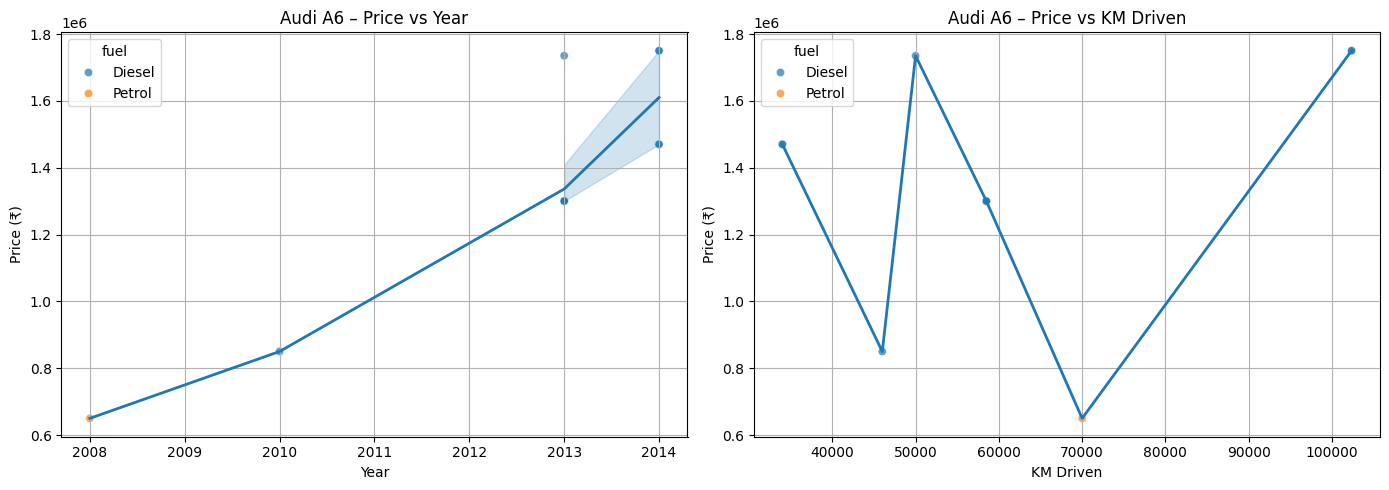

In [ ]:
# 🔥 Display all controls and output area
display(
    model_dd, year_dd, fuel_dd, trans_dd,
    seller_dd, owner_dd, kms_box,
    predict_plot_btn, unified_out
)
